# Introduction

Sleep is arguably one of the most mysterious yet essential aspects of our life. Sleep deprivation can lead to problems such as impaired cognitive function. Unfortunately, sleep disorders affect many people, disrupting both the quantity and quality of sleep. One method for identifying sleep disorders is by **analyzing sleep patterns**.

Currently, sleep stage annotation is typically performed by trained experts, a process that can take several hours to annotate a single sleep study session. This creates an opportunity for automation, where machine learning models could significantly reduce the time and effort required for this task.

However, one major challenge with using machine learning models in medical environments is their "black-box" nature, meaning their decision-making processes are often **not easily interpretable**. Recent research has aimed to address this issue by developing **interpretable models**, such as in this [SleepTransformer paper](https://arxiv.org/pdf/2105.11043.pdf), which uses transformers to enhance both performance and interpretability in sleep stage classification.

Building on this progress, the objective of this project is to employ a transformer-based model as the backbone and further enhance it by:
- exploring a **lightweight transformer** architecture ([Linformer](https://arxiv.org/abs/2006.04768)) for faster training and inference.
- including **personalization** using subject-specific information, such as gender and age, as sleep patterns are known to vary across different demographics, as mentioned [here](https://www.sleepfoundation.org/stages-of-sleep).

## Dataset

## Definitions

Since this project contains a lot of domain-specific terminology, this section is dedicated to listing all the terms in the sleep-staging and transformer modeling domains.

### Sleep-related terminologies

- **Polysomnography (PSG)**: a comprehensive diagnostic tool used in sleep studies to record various physiological functions during sleep.
- **PSG epoch**: a 30-second frame PSG recording.
- **PSG sequence**: several PSG epochs that last one recording session.
- **Electroencephalography (EEG)**: a measurement of brain wave activity, which helps to determine different sleep stages. This is one of the component of PSG.
- **Fpz-Cz EEG**: the *electrode placement* on the scalp for recording EEG signals, **Fpz** indicates to the midpoint of the forehead, while **Cz** is center of the scalp. See the picture below.

<img src="https://www.orimtec.com/images/illustration/pop/eeg/electrode_placement_diagram.jpg" alt="EEG 10.20 placement" width="200" height="200">

In general, sleeping stages are divided into eight categories:


1. **Wake (W)**: the stage when a person is awake. It is characterized by *low-voltage, mixed-frequency brain waves* on the EEG.
2. **Stage 1 Non-REM Sleep (N1)**: the *lightest stage of non-REM sleep*. It marks the transition from wakefulness to sleep.
3. **Stage 2 Non-REM Sleep (N2)**: a deeper stage of sleep characterized by *sleep spindles* (sudden bursts of brain activity) and *K-complexes* (large waves that occur in response to external stimuli).
4. **Stage 3 Non-REM Sleep (N3)**: the deepest stage of non-REM sleep.
5. **Stage 4 Non-REM Sleep (N4)**: historically, N3 and N4 were distinguished as separate stages, but they are now both considered as one stage.
6. **Rapid Eye Movement (REM)**: a unique sleep stage characterized by rapid eye movements, paradoxical brain activity (similar to being awake), and muscle atonia (loss of muscle tone).
7. **Movement**: refers to periods of muscle activity or movement during sleep.
8. **Unknown**: when the sleep stage is not clear or cannot be classified due to poor signal quality, artifacts, or insufficient data.




## Preparation

In [1]:
from google.cloud import storage

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import io
import os

In [2]:
# Helper functions

def download_data_from_gcs(bucket, file_name):
    """
        A function to download data from GCS.
        The original data is of NumPy's .npz type.
    """

    blob = bucket.blob(file_name)
    npz_bytes = blob.download_as_bytes()
    data = np.load(io.BytesIO(npz_bytes), allow_pickle=True)

    return data

In [4]:
# Create a client GCS and get the specified bucket
client = storage.Client(project=PROJECT_ID)
bucket = client.get_bucket(BUCKET_NAME)

In [59]:
# List the data files.
# Note that each file contains one PSG recording for each of the 78 subjects,
# with each subject having a 2-day recording.

data_files = !gsutil ls gs://{BUCKET_NAME}
data_files = [os.path.basename(f) for f in data_files if f[-4:]]
print(f"Number of files: {len(data_files)}")

Number of files: 45


In [60]:
# Load the data

data = []
for f in data_files:
    data.append(download_data_from_gcs(bucket, f))

# Exploratory Data Analysis

In [61]:
from scipy.signal import resample

In [62]:
# Sneak peak into the structure of the data
sample = data[0]

print(f"EEG channel label  : {sample['ch_label']}")
print(f"Sampling frequency : {sample['fs']} Hz")

print(f"EEG signal shape   : {sample['x'].shape}")
print(f"EEG label shape    : {sample['y'].shape}")
print(f"EEG labels         : {set(sample['y'])}")

print(f"Subject details    : {sample['header_raw'].item()['local_subject_id']}")

EEG channel label  : EEG Fpz-Cz
Sampling frequency : 100.0 Hz
EEG signal shape   : (841, 3000, 1)
EEG label shape    : (841,)
EEG labels         : {0, 1, 2, 3, 4}
Subject details    : X F X Female_33yr


Based on the information above, we can extract several information from our data:

**1. EEG Signal Type**

The EEG channel is labeled `EEG Fpz-Cz`, which refers to the **electrode placement** on the scalp for recording EEG signals. **Fpz** corresponds to the midpoint of the forehead, while **Cz** is the central point of the scalp.

**2. Sampling Frequency**

The sampling frequency is noted as $100 Hz$. This means 100 samples are captured per second from the continuous EEG signal.

**3. EEG Signal Shape**

The example shows a shape of `(841, 3000, 1)`, where the format is `(PSG_epochs, signals, 1)`. Each PSG epoch represents a 30-second segment, as mentioned in the paper. This can be validated by the fact that for each PSG epoch, $\frac{3000 \text{ samples}}{100 \frac{\text{samples}}{\text{second}}} = 30 \text{ seconds}$.

So, this particular recording contains approximately $\frac{841 \times 30}{3600} \approx 7 \text{ hours}$ of EEG signal.

**4. EEG Label Shape**

The number of labels matches the number of PSG epochs, which is straightforward.

**5. EEG labels**

Notice that we only have 5 labels while usually there are 8 sleep stages. This is because the label `MOVEMENT` and `UNKNOWN` are excluded while `N3` and `N4` are merged. This leave us with 5 labels:
- 0 for Wake
- 1 for N1
- 2 for N2
- 3 for N3-N4
- 4 for REM

**5. Subject Details**

The subject details include the gender and age of the subject in the recording.

For better understanding, we can plot the EEG signal along with the labels.

In [63]:
s = sample['x'].squeeze(-1)    # (841, 3000, 1) -> (841, 3000)
s = s.reshape(-1)              # (841, 3000) -> (2523000,)

# Normalize signal
min, max = s.min(), s.max()
s_norm = (2 * (s - min) / (max - min)) - 1

# Downsample signal signal to only 5 Hz -> (126150,)
fs = 100
fs_target = 5
downsample_ratio = fs//fs_target
s_downsampled = resample(s_norm, len(s)//downsample_ratio)

labels = sample['y'].repeat(30 * fs_target)    # (841,) -> (126150,)

In [64]:
# Define colors for sleep stages
colors = {0: "lightgrey",
          1: "lightyellow",
          2: "lightblue",
          3: "lightgreen",
          4: "lightpink"}

sleep_labels = {0: "Wake",
                1: "N1",
                2: "N2",
                3: "N3",
                4: "REM"}

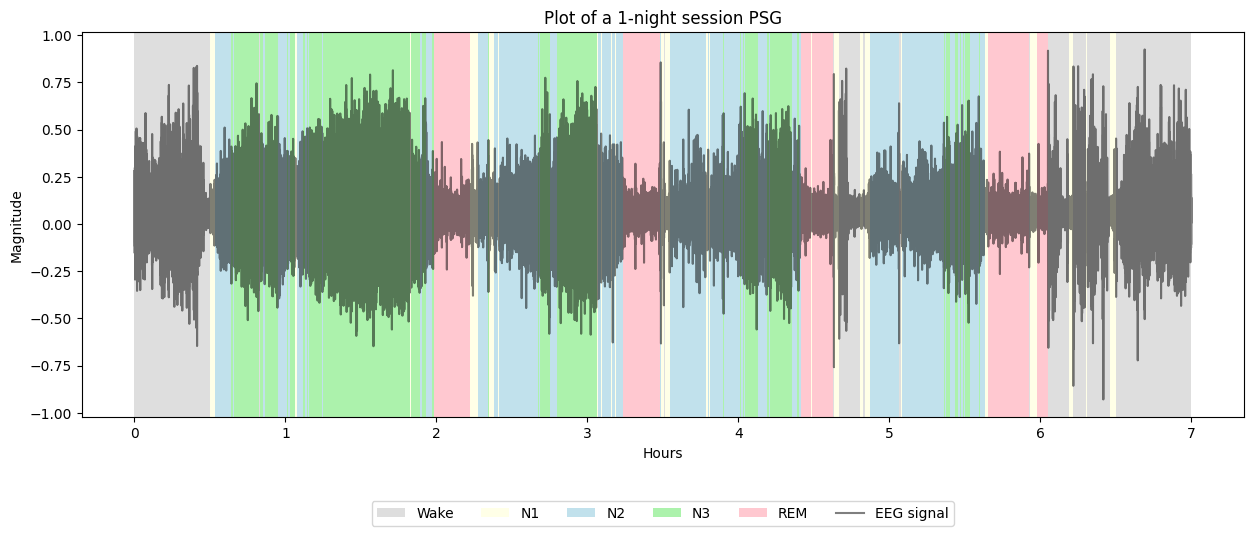

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))

prev_value = labels[0]
start_idx = 0

ts = np.linspace(0, 7, len(s_downsampled))

# Iterate through the data and change background color according to label
label_tracker = []
for i, value in enumerate(labels):
    if value != prev_value:
        # Only set label one time
        if prev_value not in label_tracker:
            label_tracker.append(prev_value)
            label = sleep_labels[prev_value]
        else:
            label = None

        # Shade the previous segment
        ax.axvspan(ts[start_idx], ts[i], facecolor=colors[prev_value],
                   label=label, alpha=0.75)
        prev_value = value
        start_idx = i

# Shade the last segment
ax.axvspan(ts[start_idx], ts[len(labels)-1], facecolor=colors[prev_value],
           label=label, alpha=0.75)

# Plot the EEG signal
ax.plot(ts, s_downsampled, alpha=0.5, color="black", label="EEG signal")
ax.set_xlabel("hours")
ax.set_ylabel("magnitude")

plt.title("Plot of a 1-night session PSG")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=6)
plt.show()

We can actually observe how the signals in each sleep stage differ from each other. To examine the characteristics further, we can also randomly choose one example from each sleep stage and plot the EEG.

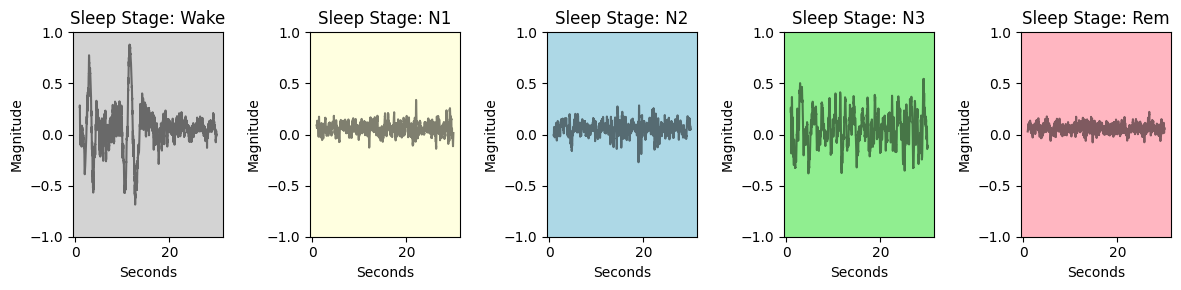

In [66]:
s = sample['x'].squeeze(-1)    # (841, 3000, 1) -> (841, 3000)

# Normalize signal
min, max = s.min(), s.max()
signal = (2 * (s - min) / (max - min)) - 1

labels = sample['y']
sleep_stages = list(set(labels))

fig, ax = plt.subplots(1, len(sleep_stages), figsize=(12, 3))

for i, stage in enumerate(sleep_stages):
    # Randomly select PSG epoch to be plotteed
    signal_plot = signal[labels == stage]
    random_index = np.random.choice(signal_plot.shape[0])
    signal_plot = signal_plot[random_index].reshape(-1)

    ts = np.linspace(1, 30, len(signal_plot))
    ax[i].plot(ts, signal_plot, alpha=0.5, color="black")
    ax[i].set_facecolor(colors[stage])
    ax[i].set_title(f"Sleep Stage: {sleep_labels[stage].title()}")
    ax[i].set_xlabel("seconds")
    ax[i].set_ylabel("magnitude")
    ax[i].set_ylim(-1, 1)

plt.tight_layout()
plt.show()

[TODO] Frequency analysis?

Next, we have check the EEG signal on each sleep stage, we can continue the data analysis to check other statistics of the dataset.

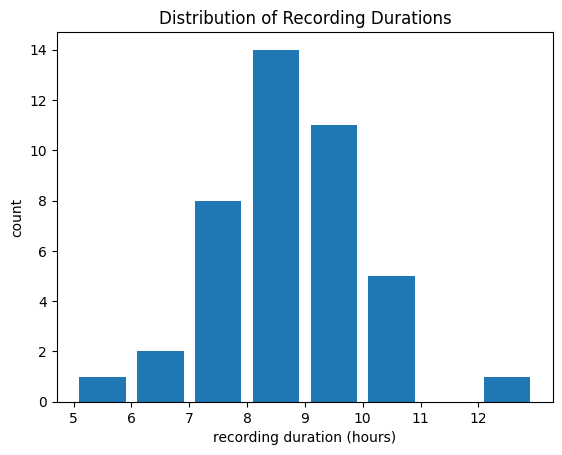

In [74]:
# Distribution of the recording length
fs = 100

rec_len = []
for sample in data:
    len_s = sample["x"].shape[0] * sample["x"].shape[1] / fs
    len_h = len_s / 3600
    rec_len.append(len_h)

plt.hist(rec_len, bins=range(5, 14), rwidth=0.8) # [7, 8, 9, 10, 11]
plt.xticks(range(5, 13))
plt.xlabel("recording duration (hours)")
plt.ylabel("count")
plt.title("Distribution of Recording Durations")
plt.show()

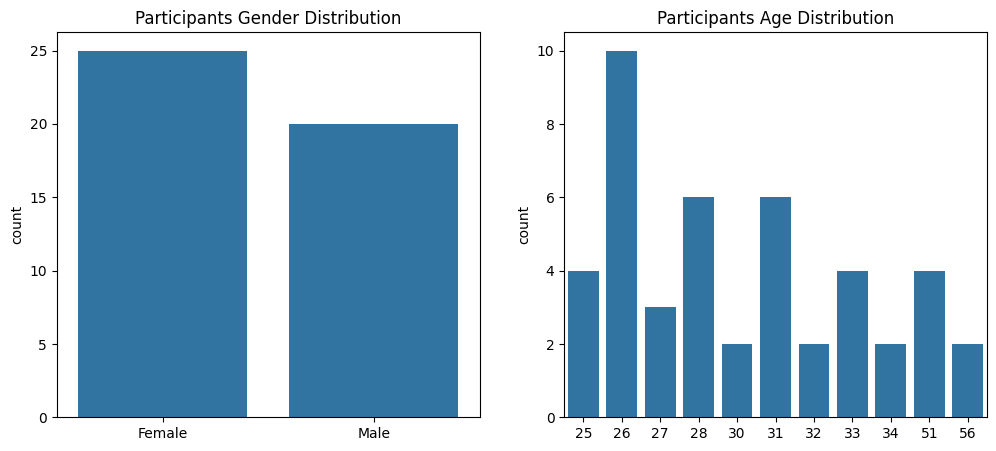

In [78]:
# Distribution of the gender and age of experiment participants
gender_info, age_info = [], []
for sample in data:
    info = sample["header_raw"].item()["local_subject_id"]
    info = info.strip().split()[-1].split("_")

    gender_info.append(info[0])
    age_info.append(info[-1][:-2])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=gender_info, ax=ax[0])
ax[0].set_title("Participants Gender Distribution")

sns.countplot(x=sorted(age_info), ax=ax[1])
ax[1].set_title("Participants Age Distribution")

plt.show()

# Data Preparation

This section contains the implementation of dataset preparation to train the tranformer model. As mentioned previously, the majority of this project will follow the implementation of [SleepTransformer](https://arxiv.org/pdf/2105.11043), including dataset preparation step.

This is quoted directly from the paper.

> As described, `SleepTransformer` ingests time-frequency images as input. To extract a time-frequency image, a 30-second
EEG epoch sampled at $100 \text{ Hz}$ was decomposed into twosecond frames with 50% overlap, multiplied with a Hamming window, and transformed to the frequency domain using a 256-point short-time Fourier Transform (STFT). This procedure
resulted in an image $S \in \mathbb{R}^{T \times F}$ with $T = 29$ time frames and $F = 128$ frequency bins. Of note, we excluded the $0-th$ frequency bin to keep $F = 128$ which is a multiple of the number of attention heads in the epoch transformer in Section IV-A. The amplitude spectrum was then log-transformed. The time-frequency images extracted from a database were normalized to zero mean and unit variance along the frequency dimension given the normalization parameters computed using the training data.

From that information we understand that the input for the `SleepTransformer` is a spectrogram which serve as the result of frequency decomposition of the input signal.




In [109]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from librosa import stft
import librosa

from functools import partial
from typing import List, Callable

In [126]:
!mkdir -p data

In [127]:
%%writefile data/transform.py
class STFTTransform:
    """ Apply Short-time Fourier Transform (STFT) to a signal. """
    def __init__(self,
                 fs: int=100, # Hz
                 n_fft: int=256,
                 win_length: int=2, # s
                 hop_length: int=1, # s
                 window_fn: str="hamming"): # Hamming window

        self.fs = fs
        self.n_fft = n_fft
        self.win_length = win_length * fs
        self.hop_length = hop_length * fs
        self.window_fn = window_fn
        self.transform_fn = partial(stft,
                                    n_fft=self.n_fft,
                                    hop_length=self.hop_length,
                                    win_length=self.win_length,
                                    window=self.window_fn,
                                    center=False)
        self.epsilon = 1e-7

    def __call__(self, x: np.ndarray):
        X = np.abs(self.transform_fn(x))  # taking the magnitude
        X_log = np.log10(X + self.epsilon)

        return X_log # eclude the 0-th frequency bin (DC)

Overwriting data/transform.py


In [122]:
x = data[0]["x"].squeeze(-1)

transform_fn = STFTTransform()
x.shape, transform_fn(x).shape

((841, 3000), (841, 129, 28))

In [ ]:
class SleepStageDataset(Dataset):
    def __init__(self,
                 records: List[np.lib.npyio.NpzFile], # List of raw data
                 sequence_length: int=21, # Number of PSG epochs to include in a sequence
                 n_records: int=None, # Total number of recordings to be included
                 fs: int=100, # Sampling rate
                )

        self.n_records = len(records)
        self.record_metadata = {}
        self.index_to_record = []
        self.scaler = StandardScaler()

        self.label_value = {
            0: "Wake",
            1: "N1",
            2: "N2",
            3: "N3",
            4: "REM"
        }

    def __len__(self):
        pass

    def __getitem__(self):
        pass

# References

- https://arxiv.org/pdf/2105.11043
- https://researchdata.ntu.edu.sg/dataverse/attnSleep
- https://www.youtube.com/watch?v=ISNdQcPhsts&t=5553s